<a href="https://colab.research.google.com/github/Rogerio-mack/data-engineering/blob/main/aula07_pymongo_grafana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MongoDB Atlas, `pymongo` & Grafana


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

import base64
import json
import pprint

## Pre-requisitos

Crie uma conta free no no Cloud [MongoDB Atlas](mongodb.com) e no [Grafana](https://grafana.com/auth/sign-in).

No MongoDB crie um cluster e obtenha a sua string de conexão.


In [2]:
senha = input('Entre com sua senha do MongoDB Atlas:')

Entre com sua senha do MongoDB Atlas:rdeoliveirag


In [3]:
ATLAS_URI = "mongodb+srv://rdeoliveirag:" + senha + "@cluster0.bfq2t.mongodb.net/?retryWrites=true&w=majority&appName=Cluster0"

Install `pymongo`


In [4]:
! pip install -qU pymongo==4.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 677.2/677.2 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 17.7 MB/s eta 0:00:00


In [5]:
from pymongo import MongoClient

## Define the Atlas Client class




In [6]:
class AtlasClient:

    def __init__(self, altas_uri, dbname):
        self.mongodb_client = MongoClient(altas_uri)
        self.database = self.mongodb_client[dbname]

    # A quick way to test if we can connect to Atlas instance
    def ping(self):
        self.mongodb_client.admin.command("ping")

    # Get the MongoDB Atlas collection to connect to
    def get_collection(self, collection_name):
        collection = self.database[collection_name]
        return collection

    # Query a MongoDB collection
    def find(self, collection_name, filter={}, limit=0):
        collection = self.database[collection_name]
        items = list(collection.find(filter=filter, limit=limit))
        return items

## Connect to MongoDB Atlas

Se a conexão falhar verifique se a opção **Connect From Anywhere** está habilitada (is enabled) no **Atlas network configuration**>

In [7]:
DB_NAME = "mydb"
COLLECTION_NAME = "my_series"

atlas_client = AtlasClient(ATLAS_URI, DB_NAME)
atlas_client.ping()
print("Connected to Atlas instance! We are good to go!")

Connected to Atlas instance! We are good to go!


## Create a Collection and Documents

In [8]:
df = pd.read_csv('https://github.com/Rogerio-mack/data-engineering/raw/main/data/Beatles_songs.csv')
beatles_songs_by_year = pd.DataFrame(df.groupby('Year').Title.count())
beatles_songs_by_year = beatles_songs_by_year.rename(columns={'Title': 'Songs'}).reset_index()
beatles_songs_by_year.head()

,Year,Songs
0,1958,2
1,1960,4
2,1961,3
3,1962,20
4,1963,66


In [9]:
import pymongo

db = atlas_client.database

db.my_series.delete_one({"name": "Beatles"})

db.my_series.insert_one({
    "name": "Beatles",
    "description": "Número de músicas lançadas pelos Beatles anualmente",
    "start_date": str(beatles_songs_by_year.Year.min()),
    "end_date": str(beatles_songs_by_year.Year.max()),
    "year": beatles_songs_by_year.Year.tolist(),
    "value": beatles_songs_by_year.Songs.tolist()
})



InsertOneResult(ObjectId('66d7b2a2f0579c2c825ac680'), acknowledged=True)

In [11]:
result = db.my_series.find_one({"name": "Beatles"})

pprint.pprint(result)


{'_id': ObjectId('66d7b2a2f0579c2c825ac680'),
 'description': 'Número de músicas lançadas pelos Beatles anualmente',
 'end_date': '1980',
 'name': 'Beatles',
 'start_date': '1958',
 'value': [2, 4, 3, 20, 66, 41, 37, 19, 27, 45, 43, 1, 1, 1],
 'year': [1958,
          1960,
          1961,
          1962,
          1963,
          1964,
          1965,
          1966,
          1967,
          1968,
          1969,
          1970,
          1977,
          1980]}


### Query

Empregaremos essa query para criar nosso dashboard.

In [14]:
result = db.my_series.aggregate([
  { "$match": { "name": "Beatles" } },
  { "$unwind": "$value" },
  { "$project": { "_id": 0, "value": 1 } }
])

pprint.pprint(list(result))


[{'value': 2},
 {'value': 4},
 {'value': 3},
 {'value': 20},
 {'value': 66},
 {'value': 41},
 {'value': 37},
 {'value': 19},
 {'value': 27},
 {'value': 45},
 {'value': 43},
 {'value': 1},
 {'value': 1},
 {'value': 1}]


## Adicionando Arquivos, imagens, `.pdf`, `.csv` e outros

Para incluir arquivos .csv, .pdf, .png, .mp4, .avi etc. em um documento MongoDB, você pode utilizar o **GridFS**, que é um sistema de armazenamento de arquivos oferecido pelo MongoDB para armazenar e recuperar arquivos grandes que superam o limite de tamanho de documentos BSON (16 MB). As instruções são as mesmas para quaisquer tipos de arquivos. Aqui empregaremos fotos no formato .png.

O GridFS divide o arquivo em pequenos pedaços (geralmente 255 KB) e os armazena como documentos separados em duas coleções:

* `fs.files`: armazena informações de metadados do arquivo (como o nome, o tipo, o tamanho, etc.).
* `fs.chunks`: armazena os pedaços reais do arquivo.

Você pode acessar essas coleções na console do MongoDB Atlas.

Se os arquivos forem pequenos e não superarem o limite de 16 MB, você também pode simplesmente armazená-los como Base64 diretamente em um documento MongoDB, sem necessidade do GridFS.


In [15]:
!wget https://www.udiscovermusic.com/wp-content/uploads/2020/08/Abbey-Road.jpg -O beatles.jpg


--2024-09-04 01:16:36--  https://www.udiscovermusic.com/wp-content/uploads/2020/08/Abbey-Road.jpg
Resolving www.udiscovermusic.com (www.udiscovermusic.com)... 45.60.62.1
Connecting to www.udiscovermusic.com (www.udiscovermusic.com)|45.60.62.1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169603 (166K) [image/jpeg]
Saving to: ‘beatles.jpg’

beatles.jpg         100%[===================>] 165.63K  1.05MB/s    in 0.2s    

2024-09-04 01:16:36 (1.05 MB/s) - ‘beatles.jpg’ saved [169603/169603]



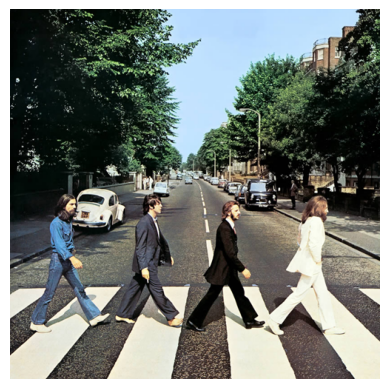

In [13]:
def resize_image(image_path, new_width=500):
  image = Image.open(image_path)

  # Calculate the new dimensions with proportions
  width, height = image.size
  new_width = new_width
  new_height = int(new_width/width * height)

  # Resize the image
  resized_image = image.resize((new_width, new_height),reducing_gap=1)

  return resized_image

resized_image = resize_image('beatles.jpg')
plt.imshow(resized_image)
plt.axis('off')
plt.show()
resized_image.save('beatles.png')



### Adicionando um arquivo com o `GridFS`

In [17]:
import gridfs

fs = gridfs.GridFS(db)

# Upload de uma imagem .png
with open("beatles.png", "rb") as file:
    foto_id = fs.put(file, filename="beatles.jpg")

result = db.my_series.update_one(
              {"name": "Beatles"},
              {"$set": {
                  "foto_id": foto_id
                  }
              }
          )

pprint.pprint(result)

UpdateResult({'n': 1, 'electionId': ObjectId('7fffffff000000000000004a'), 'opTime': {'ts': Timestamp(1725412682, 9), 't': 74}, 'nModified': 1, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1725412682, 9), 'signature': {'hash': b'}\xdd\x19d\xa5\xb4U\xda\xcc\xcf\xc0\xbc\xbb\xbe!a\x85\xe6\xf7\x99', 'keyId': 7367810001634590727}}, 'operationTime': Timestamp(1725412682, 9), 'updatedExisting': True}, acknowledged=True)


In [18]:
result = db.my_series.find_one({"name": "Beatles"})

pprint.pprint(result)

{'_id': ObjectId('66d7b2a2f0579c2c825ac680'),
 'description': 'Número de músicas lançadas pelos Beatles anualmente',
 'end_date': '1980',
 'foto_id': ObjectId('66d7b546f0579c2c825ac681'),
 'name': 'Beatles',
 'start_date': '1958',
 'value': [2, 4, 3, 20, 66, 41, 37, 19, 27, 45, 43, 1, 1, 1],
 'year': [1958,
          1960,
          1961,
          1962,
          1963,
          1964,
          1965,
          1966,
          1967,
          1968,
          1969,
          1970,
          1977,
          1980]}


In [19]:
# Recuperando a imagem
foto_id = db.my_series.find_one({"name": "Beatles"})["foto_id"]

# Download do arquivo
with open("downloaded_foto_id.png", "wb") as file:
    file.write(fs.get(foto_id).read())



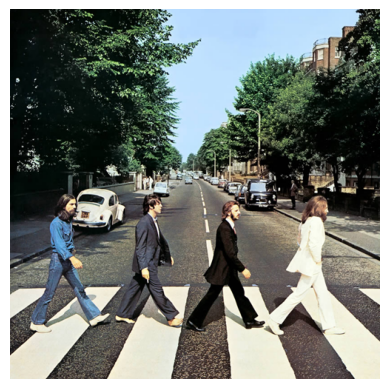

In [20]:
plt.imshow(Image.open('downloaded_foto_id.png'))
plt.axis('off')
plt.show()


### Adicionando um arquivo em `base64`

> Base64 é um esquema de codificação usado para converter dados binários (como arquivos de imagem, áudio ou texto) em uma sequência de caracteres ASCII. Isso permite que dados binários sejam transmitidos em formatos que esperam apenas texto, como e-mails, URLs, JSON e XML. A codificação Base64 usa um conjunto de 64 caracteres (A-Z, a-z, 0-9, +, /) e é comum em aplicações da web para transportar dados binários através de canais de comunicação que não suportam conteúdo binário diretamente.

In [21]:
with open("beatles.png", "rb") as file:
    encoded_foto = base64.b64encode(file.read()).decode("utf-8")

result =  db.my_series.update_one(
              {"name": "Beatles"},
              {"$set": {
                  "foto_base64": encoded_foto
                  }
              }
          )

pprint.pprint(result)


UpdateResult({'n': 1, 'electionId': ObjectId('7fffffff000000000000004a'), 'opTime': {'ts': Timestamp(1725413016, 2), 't': 74}, 'nModified': 1, 'ok': 1.0, '$clusterTime': {'clusterTime': Timestamp(1725413016, 2), 'signature': {'hash': b'\x91\x9b\x90\x84\x04\xcf\x04~\x9dPHb\xac\x91_U\xc80\xff\xf0', 'keyId': 7367810001634590727}}, 'operationTime': Timestamp(1725413016, 2), 'updatedExisting': True}, acknowledged=True)


In [22]:
result = db.my_series.find_one({"name": "Beatles"})

pprint.pprint(result)

{'_id': ObjectId('66d7b2a2f0579c2c825ac680'),
 'description': 'Número de músicas lançadas pelos Beatles anualmente',
 'end_date': '1980',
 'foto_base64': 'iVBORw0KGgoAAAANSUhEUgAAAfQAAAH0CAIAAABEtEjdAAEAAElEQVR4nOx9d3xdR5X/tFteL+q9S7ZkWe4tbnHsOInTC4QUICxlgV1gWfousMDuspQQOiQQSEhCSK+OHffeJVm99/56f7fNzO+PJymSnJgEsuW3m/Pxx5/3dO+dO3fe3DNnvud7zoEZOdmRSETTNIwxAABCiBDinHPOGaMcMPCGQAhQ6pzZ/2eFcz73K4AcgPl/mXsQ4HnXAooQAgAwxjjnEEIIIaWUc261WXXGqKqJoli3pHZ4ZNjr83EIF9fWFBQW5ufnjoyONDY0hsOx9PSMDWvWjAwNtbS0AAASiQTnjDOGEOScc8AxFq1WK6WUUmpQqukaFgQAAEKIYKJFEwagBWWFOtOd6e7cojxJZEos3tHUPzXhRZwDhiCEBDBDZxxCCjhEIqcYEcqoNtvtBcPC0LyvM+M4PYCUs9TYzQwLnB5JxgDjAEJIMOcccC6bTCaTHIlEmEYh4JgQSqksyzk5OS6Xy5XhPnr0qGHoCGPAAaeAiAI1DMaYyWwury71+ryQg+UrV545eSrqi9nsdr/HyyFABHNOEcGcMcA4NluqlteUlKZHY2EtiU69duoD997X1tYYiU1ds+vqtta2c6eaXS7bJz9zb1/PWFP32C13vP+xR37V19ZWXX7VTR/4zPptxS+9fv9gf/z662998P5/U6JJ31Q4O7/mX777gDu7MBDy5xbkQiBKoigAYBggGk+IIjF0gWM2O26cQ8bfZNBmjgL+ltPqr5K5E5hxzubcBXIwt0OXn/kIv2XnAQCAX/ateWth81tdcCEGbz1i8+8JAZg7J

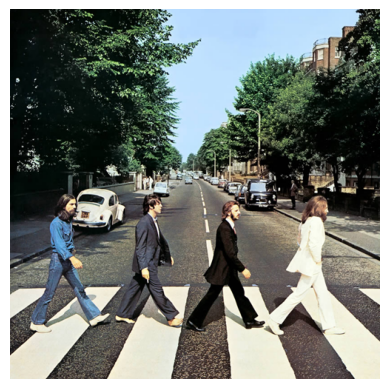

In [23]:
# Recuperar o arquivo Base64 do MongoDB
foto_encoded = db.my_series.find_one({"name": "Beatles"})["foto_base64"]

# Decodificar e salvar como um arquivo
with open("downloaded_foto_base64.png", "wb") as file:
    file.write(base64.b64decode(foto_encoded))

plt.imshow(Image.open('downloaded_foto_base64.png'))
plt.axis('off')
plt.show()


### Query

Empregaremos essa query para criar nosso dashboard.

In [86]:
result = db.my_series.find_one({"name": "Beatles"},{'_id':0, 'foto_base64':1})
pprint.pprint(result)

{'foto_base64': 'iVBORw0KGgoAAAANSUhEUgAAAfQAAAH0CAIAAABEtEjdAAEAAElEQVR4nOx9d3xdR5X/tFteL+q9S7ZkWe4tbnHsOInTC4QUICxlgV1gWfousMDuspQQOiQQSEhCSK+OHffeJVm99/56f7fNzO+PJymSnJgEsuW3m/Pxx5/3dO+dO3fe3DNnvud7zoEZOdmRSETTNIwxAABCiBDinHPOGaMcMPCGQAhQ6pzZ/2eFcz73K4AcgPl/mXsQ4HnXAooQAgAwxjjnEEIIIaWUc261WXXGqKqJoli3pHZ4ZNjr83EIF9fWFBQW5ufnjoyONDY0hsOx9PSMDWvWjAwNtbS0AAASiQTnjDOGEOScc8AxFq1WK6WUUmpQqukaFgQAAEKIYKJFEwagBWWFOtOd6e7cojxJZEos3tHUPzXhRZwDhiCEBDBDZxxCCjhEIqcYEcqoNtvtBcPC0LyvM+M4PYCUs9TYzQwLnB5JxgDjAEJIMOcccC6bTCaTHIlEmEYh4JgQSqksyzk5OS6Xy5XhPnr0qGHoCGPAAaeAiAI1DMaYyWwury71+ryQg+UrV545eSrqi9nsdr/HyyFABHNOEcGcMcA4NluqlteUlKZHY2EtiU69duoD997X1tYYiU1ds+vqtta2c6eaXS7bJz9zb1/PWFP32C13vP+xR37V19ZWXX7VTR/4zPptxS+9fv9gf/z662998P5/U6JJ31Q4O7/mX777gDu7MBDy5xbkQiBKoigAYBggGk+IIjF0gWM2O26cQ8bfZNBmjgL+ltPqr5K5E5hxzubcBXIwt0OXn/kIv2XnAQCAX/ateWth81tdcCEGbz1i8+8JAZg7JRc8C4QAXrb7b1/gwg6/5aH/PFmok+DbOgQAgIiBt5aFg/a2JySE02835AwCAAUxEgqM9XXJQH36sd83XziuqzpnwqqV69/3vjsDbKSjrbnxfL13fPLO972/vb394MGDnLPS0vLFi6t

# Grafana Dashboard

1. https://grafana.com/auth/sign-in

2. create a free account

3. launch grafana cloud

Você pode baixar o Grafana para Windows, Linux ou Mac, mas não poderá com essas versões compartilhar diretamente seus dashboards na internet.

Exemplo [aqui](https://rdeoliveirag.grafana.net/public-dashboards/ed76c8a4c0b44961a4d7a6058c87dcae).



## Plug-ins

No Grafana,

1. Instale o plug-in do MongoDB
2. Instale o plug-in do volkovlabs-image-panel (para imagens base64)

Você ainda pode instalar plugins para outras fontes de dados como arquivos (.csv etc.), Google Sheets, webpages (pago), outros bancos de dados etc.

* [play.grafana.org](https://play.grafana.org/), Play is a sandbox for testing and learning Grafana that runs on Grafana Cloud. Including [MongoDB: Movie Database
](https://play.grafana.org/d/kl3P3sJnk/mongodb3a-movie-database?var-_movie=Brooklyn%20Castle&var-_year=2012)
* [Video: How to get started with MongoDB and Grafana](https://grafana.com/blog/2022/08/09/video-how-to-get-started-with-mongodb-and-grafana/)
* [volkovlabs-image-panel help vídeo](https://youtu.be/1_bgLSehjhg?si=GyQ05dWxhLLEay9S)


## Data Source

Defina e configure sua fonte dados MongoDB com sua string de conexão (string do Compass no MongoDB) e credenciais de acesso.


In [ ]:
%%script echo skipping
mongodb+srv://cluster0.bfq2t.mongodb.net/

Teste sua conexão e em seguida explore os dados.

In [ ]:
%%script echo skipping
mydb.my_series.aggregate({})

## Dashboard

### *Time Series*, Stat

Aqui empregamos o gráfico `Stat`. Time Series requerem dados com datas. Transformações de dados para numéricos podem também ser necessárias.

In [97]:
result = db.my_series.aggregate([
  { "$match": { "name": "Beatles" } },
  { "$unwind": "$value" },
  { "$project": { "_id": 0, "value": 1 } }
])

pprint.pprint(list(result))


[{'value': 2},
 {'value': 4},
 {'value': 3},
 {'value': 20},
 {'value': 66},
 {'value': 41},
 {'value': 37},
 {'value': 19},
 {'value': 27},
 {'value': 45},
 {'value': 43},
 {'value': 1},
 {'value': 1},
 {'value': 1}]


In [91]:
%%script echo skipping
mydb.my_series.aggregate([
  { $match: { name: "Beatles" } },
  { $unwind: "$value" },
  { $project: { _id: 0, value: 1 } }
])

skipping


### *Gauge*, Alertas

Gráficos de Gauge são úteis para alertas e podem ser feitos sobre cada valor ou computados (totais, cálculos etc.).

In [ ]:
%%script echo skipping
mydb.my_series.aggregate([
  { $match: { name: "Beatles" } },
  { $unwind: "$value" },
  { $project: { _id: 0, value: 1 } }
])

skipping


### *Photo*

Você pode recuperar a imagem em formato base64 do MongoDB e empregar o plug-in volkovlabs-image-panel no lugar de um gráfico.

1. Alterne a visualização para table view para ver os dados em base64 retornados pela sua query.
2. Defina o gráfico `Business Media`
3. Em  `Business Media` escolha o campo (aqui, `foto_base64`). **Dê +Add**.

In [100]:
result = db.my_series.find({"name": "Beatles"},{"_id":0, "foto_base64":1})
pprint.pprint(list(result)[0])

{'foto_base64': 'iVBORw0KGgoAAAANSUhEUgAAAfQAAAH0CAIAAABEtEjdAAEAAElEQVR4nOx9d3xdR5X/tFteL+q9S7ZkWe4tbnHsOInTC4QUICxlgV1gWfousMDuspQQOiQQSEhCSK+OHffeJVm99/56f7fNzO+PJymSnJgEsuW3m/Pxx5/3dO+dO3fe3DNnvud7zoEZOdmRSETTNIwxAABCiBDinHPOGaMcMPCGQAhQ6pzZ/2eFcz73K4AcgPl/mXsQ4HnXAooQAgAwxjjnEEIIIaWUc261WXXGqKqJoli3pHZ4ZNjr83EIF9fWFBQW5ufnjoyONDY0hsOx9PSMDWvWjAwNtbS0AAASiQTnjDOGEOScc8AxFq1WK6WUUmpQqukaFgQAAEKIYKJFEwagBWWFOtOd6e7cojxJZEos3tHUPzXhRZwDhiCEBDBDZxxCCjhEIqcYEcqoNtvtBcPC0LyvM+M4PYCUs9TYzQwLnB5JxgDjAEJIMOcccC6bTCaTHIlEmEYh4JgQSqksyzk5OS6Xy5XhPnr0qGHoCGPAAaeAiAI1DMaYyWwury71+ryQg+UrV545eSrqi9nsdr/HyyFABHNOEcGcMcA4NluqlteUlKZHY2EtiU69duoD997X1tYYiU1ds+vqtta2c6eaXS7bJz9zb1/PWFP32C13vP+xR37V19ZWXX7VTR/4zPptxS+9fv9gf/z662998P5/U6JJ31Q4O7/mX777gDu7MBDy5xbkQiBKoigAYBggGk+IIjF0gWM2O26cQ8bfZNBmjgL+ltPqr5K5E5hxzubcBXIwt0OXn/kIv2XnAQCAX/ateWth81tdcCEGbz1i8+8JAZg7JRc8C4QAXrb7b1/gwg6/5aH/PFmok+DbOgQAgIiBt5aFg/a2JySE02835AwCAAUxEgqM9XXJQH36sd83XziuqzpnwqqV69/3vjsDbKSjrbnxfL13fPLO972/vb394MGDnLPS0vLFi6t

In [ ]:
%%script echo skipping
mydb.my_series.find({"name": "Beatles"},{"_id":0, "foto_base64":1})

### Layout & Publish

1. Ajuste o layout do gráfico da forma que preferir.
2. Altere preferências de `Refresh`.
2. Saia do modo de edição. Em `Share > Public Dashboard` compartilhe seu gráfico na web. Exemplo [aqui](https://rdeoliveirag.grafana.net/public-dashboards/ed76c8a4c0b44961a4d7a6058c87dcae).






# Lab

Neste Lab você irá implementar um dashboard do Grafana exbindo dados de ativos de ações do IBOVESPA (ou de outro mercado de seu interesse) a partir do MongoDB.

1. **Atividade em grupo**. Min 2 alunos, Max 4 alunos

1. **Tarefas gerais da atividade**

  1. Crie contas no Grafana e MongoDB Atlas Cloud
  2. Empregue a biblioteca `yfinance` para obter dados dos ativos (mínimo 3 ativos e valores dos últimos 12 meses)
  3. Crie uma coleção `Ativos` em que cada ativo da bolsa e sua série de valores constitui um documento da coleção. Opcionalmente adicione informações de cada empresa, como área de atuação.
  4. Adicione ao documento uma foto representativa de cada uma das empresas. Empregue o formato base64. Certifique-se que o arquivo final não supera 16MB.
  5. Construa um dashboard no Grafana Cloud apresentando no mínimo, a foto da empresa, a série de valores e um alerta.
  6. Compartilhe publicamente o dashboard.
  6. Opcionalmente (+1), implemente no dashboard um filtro com o nome do ativo a ser exibido.

3. **Entregas**

  1. Poste um notebook completo, 100% executável, com a preparação e a carga dos dados.
  2. Informe no texto inicial do notebook:

    1. Os integrantes do grupo
    2. O link público do dashboard em modo de edição (ou forneça o usuário senha)